In [1]:
! pip install -U segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 69.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=426956818292a6f81878a46b72b24d9368c7f80245b718c21d5ce7fedf3e24cd
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=e8a3dd7a3872d1ecd8c23944492a935f1cecb1605e04d0d8ffb4dbc927267f76
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

# Extracting Zip File

In [2]:
import os
import zipfile

# Define the paths to the datasets
zip_files = {
    'stage1_train.zip': '/kaggle/input/data-science-bowl-2018/stage1_train.zip',
    'stage1_solution.csv.zip': '/kaggle/input/data-science-bowl-2018/stage1_solution.csv.zip',
    'stage1_test.zip' : '/kaggle/input/data-science-bowl-2018/stage1_test.zip'
}

# Corresponding output directories
output_dirs = {
    'stage1_train.zip': '/kaggle/working/stage1_train/',
    'stage1_solution.csv.zip': '/kaggle/working/stage1_solution/',
    'stage1_test.zip' : '/kaggle/working/stage1_test/'
}

# Unzip each file to its respective directory
for zip_filename, zip_path in zip_files.items():
    extracted_path = output_dirs[zip_filename]
    
    # Ensure the directory exists
    os.makedirs(extracted_path, exist_ok=True)

    # Unzip the file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

    #print(f"Unzipping of {zip_filename} completed successfully into {extracted_path}!")

# Importing Data


# Training Data

In [3]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A  # Using Albumentations for augmentations
from albumentations.pytorch import ToTensorV2

class SegmentationDataset(Dataset):
    def __init__(self, base_path, transform=None):
        self.base_path = base_path
        self.transform = transform
        self.image_ids = os.listdir(base_path)

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        # Get the folder corresponding to the current index
        image_id = self.image_ids[idx]
        
        # Paths to the image and masks folder
        image_folder = os.path.join(self.base_path, image_id, 'images')
        masks_folder = os.path.join(self.base_path, image_id, 'masks')

        # Load the image
        image_path = os.path.join(image_folder, os.listdir(image_folder)[0])
        image = cv2.imread(image_path)  # Using cv2 to read the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB format

        # Normalize image to [0, 1] range
        image = image.astype(np.float32) / 255.0

        # Initialize a blank mask with the same height and width as the image
        combined_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

        # Combine all masks for the image
        for mask_filename in os.listdir(masks_folder):
            mask_path = os.path.join(masks_folder, mask_filename)
            mask = cv2.imread(mask_path, 0)  # Read the mask in grayscale mode
            combined_mask = np.maximum(combined_mask, mask)  # Combine masks

        # Normalize mask to [0, 1] range
        combined_mask = combined_mask.astype(np.float32) / 255.0

        # Apply transformations if any
        if self.transform is not None:
            augmented = self.transform(image=image, mask=combined_mask)
            image = augmented['image'].float()  # Convert image to float32
            combined_mask = augmented['mask'].float()  # Convert mask to float32
            
        # Convert the mask to have a single channel dimension
        combined_mask = combined_mask.unsqueeze(dim=0)
        
        return image, combined_mask

# Define transformations using Albumentations
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomRotate90(p=0.5),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalizing to ImageNet standards
    ToTensorV2()
])

# Instantiate the dataset
base_path = '/kaggle/working/stage1_train'
dataset = SegmentationDataset(base_path, transform=transform)

# Split the dataset into training and validation sets (70-30 split)
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Testing Data

In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2

# Define the paths to the dataset
test_image_path = "/kaggle/working/stage1_test"
solution_path = "/kaggle/working/stage1_solution/stage1_solution.csv"

# Load the solution CSV
solution_df = pd.read_csv(solution_path)

def rle_decode(encoded_pixels, height, width):
    """
    Decode run-length encoded (RLE) pixels into a mask.
    """
    mask = np.zeros(height * width, dtype=np.uint8)
    
    if encoded_pixels:  # Check if RLE is not empty
        s = encoded_pixels.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1  # Convert to zero indexing
        for start, length in zip(starts, lengths):
            mask[start:start + length] = 1

    return mask.reshape((height, width), order='F')

# Create a dictionary to store the decoded masks for each image
image_masks = {}
for image_id, group in solution_df.groupby('ImageId'):
    # Initialize a blank mask for the current image
    height = group['Height'].iloc[0]
    width = group['Width'].iloc[0]
    combined_mask = np.zeros((height, width), dtype=np.uint8)
    
    # Decode each RLE and combine them into a single mask
    for encoded_pixels in group['EncodedPixels']:
        if pd.notna(encoded_pixels):  # Check if RLE is not NaN
            mask = rle_decode(encoded_pixels, height, width)
            combined_mask = np.maximum(combined_mask, mask)  # Combine masks
    
    # Store the combined mask
    image_masks[image_id] = combined_mask

# Define the Dataset class for test images
class TestSegmentationDataset(Dataset):
    def __init__(self, image_path, masks_dict, transform=None):
        self.image_path = image_path
        self.image_ids = list(masks_dict.keys())
        self.masks_dict = masks_dict
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_folder = os.path.join(self.image_path, image_id, 'images')
        image_path = os.path.join(image_folder, os.listdir(image_folder)[0])
        
        # Load the image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        
        # Normalize image to [0, 1] range
        image = image.astype(np.float32) / 255.0
        
        # Load the mask
        mask = self.masks_dict[image_id]
        
        # Normalize mask to [0, 1] range
        mask = mask.astype(np.float32)

        # Apply transformations if any
        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        # Convert the mask to have a single channel dimension
        mask = mask.unsqueeze(dim=0)
        
        return image, mask

# Define transformations (if needed)
transform = A.Compose([
    A.Resize(256, 256),
    # A.HorizontalFlip(p=0.5),
    # A.RandomRotate90(p=0.5),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalizing to ImageNet standards
    ToTensorV2()
])

# Instantiate the test dataset
test_dataset = TestSegmentationDataset(test_image_path, image_masks, transform=transform)

# Create DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

# Data Statistics

In [5]:
print(f"Length of Train Dataset: {len(train_dataset)}")
print(f"Length of Train Dataset: {len(val_dataset)}")
print(f"Length of Train Dataset: {len(test_dataset)}")

Length of Train Dataset: 468
Length of Train Dataset: 202
Length of Train Dataset: 65


# Data Inspection

In [6]:
import cv2
import numpy as np

'''Image=cv2.imread("/kaggle/input/massachusetts-buildings-dataset/png/train/22678915_15.png")
Mask=image=cv2.imread("/kaggle/input/massachusetts-buildings-dataset/png/train_labels/22678915_15.png")

print(f'Original mask shape:{Image.shape}')

print(f'Original mask shape:{Mask.shape}')'''

#print(np.unique(Mask))

image, mask = train_dataset[2]

print(f'Transformed Image shape:{image.shape}')
print(f'Transformed mask shape:{mask.shape}')

print(f'Mask Values  : {torch.unique(mask)}')
print(f'Image Values  : {torch.unique(image)}')

print(torch.unique(mask).numel())



Transformed Image shape:torch.Size([3, 256, 256])
Transformed mask shape:torch.Size([1, 256, 256])
Mask Values  : tensor([0., 1.])
Image Values  : tensor([0.0039, 0.0078, 0.0118, 0.0157, 0.0196, 0.0235, 0.0275, 0.0314, 0.0353,
        0.0392, 0.0431, 0.0471, 0.0510, 0.0549, 0.0588, 0.0627, 0.0667, 0.0706,
        0.0745, 0.0784, 0.0824, 0.0863, 0.0902, 0.0941, 0.0980, 0.1020, 0.1059,
        0.1098, 0.1137, 0.1176, 0.1216, 0.1255, 0.1294, 0.1333, 0.1373, 0.1412,
        0.1451, 0.1490, 0.1529, 0.1569, 0.1608, 0.1647, 0.1686, 0.1725, 0.1765,
        0.1804, 0.1843, 0.1882, 0.1922, 0.1961, 0.2000, 0.2039, 0.2078, 0.2118,
        0.2157, 0.2196, 0.2235, 0.2275, 0.2314, 0.2353, 0.2392, 0.2431, 0.2471,
        0.2510, 0.2549, 0.2588, 0.2627, 0.2667, 0.2706, 0.2745, 0.2784, 0.2824,
        0.2863, 0.2902, 0.2941, 0.2980, 0.3020, 0.3059, 0.3098, 0.3137, 0.3176,
        0.3216, 0.3255, 0.3294, 0.3333, 0.3373, 0.3412, 0.3451, 0.3490, 0.3529,
        0.3569, 0.3608, 0.3647, 0.3725])
2


In [7]:
image, mask = test_dataset[2]

print(f'Transformed Image shape:{image.shape}')
print(f'Transformed mask shape:{mask.shape}')

print(f'Mask Values  : {torch.unique(mask)}')
print(f'Image Values  : {torch.unique(image)}')

print(torch.unique(mask).numel())


Transformed Image shape:torch.Size([3, 256, 256])
Transformed mask shape:torch.Size([1, 256, 256])
Mask Values  : tensor([0., 1.])
Image Values  : tensor([0.0000, 0.0078, 0.0157, 0.0235, 0.0353, 0.0431, 0.0510, 0.0588, 0.0706,
        0.0784, 0.0863, 0.0980, 0.1059, 0.1137, 0.1216, 0.1333, 0.1412, 0.1490,
        0.1569, 0.1686, 0.1765, 0.1843, 0.1961, 0.2039, 0.2118, 0.2196, 0.2314,
        0.2392, 0.2471, 0.2588, 0.2667, 0.2745, 0.2824, 0.2941, 0.3020, 0.3098,
        0.3176, 0.3294, 0.3373, 0.3451, 0.3569, 0.3647, 0.3725, 0.3804, 0.3922,
        0.4000, 0.4078, 0.4196, 0.4275, 0.4353, 0.4431, 0.4549, 0.4627, 0.4706,
        0.4784, 0.4902, 0.4980, 0.5059, 0.5176, 0.5255, 0.5333, 0.5412, 0.5529,
        0.5608, 0.5686, 0.5765, 0.5882, 0.5961, 0.6039, 0.6157, 0.6235, 0.6314,
        0.6392, 0.6510, 0.6588, 0.6667, 0.6784, 0.6863, 0.6941, 0.7020, 0.7137,
        0.7216, 0.7294, 0.7373, 0.7490, 0.7569, 0.7647, 0.7765, 0.7843, 0.7922,
        0.8000, 0.8118, 0.8196, 0.8275, 0.8392, 0.847

# Data Visualization

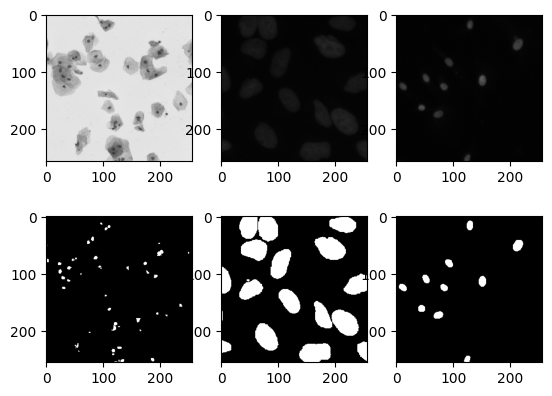

In [8]:
import matplotlib.pyplot as plt

for i in range(3):
    image, mask=train_dataset[i]
    plt.subplot(2,3,i+1)
    plt.imshow(image.permute(1,2,0),cmap='gray')
    plt.subplot(2,3,3+i+1)
    plt.imshow(mask.permute(1,2,0),cmap='gray')

plt.show()

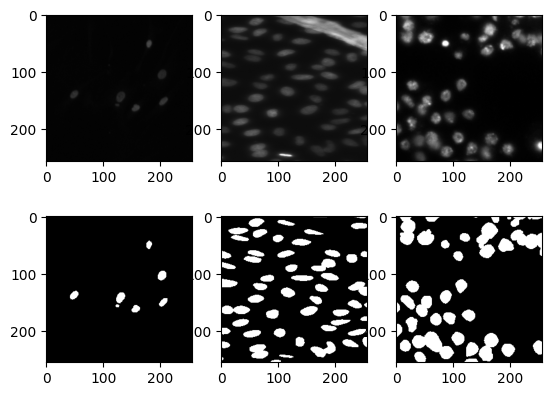

In [9]:
import matplotlib.pyplot as plt

for i in range(3):
    image, mask=test_dataset[i]
    plt.subplot(2,3,i+1)
    plt.imshow(image.permute(1,2,0),cmap='gray')
    plt.subplot(2,3,3+i+1)
    plt.imshow(mask.permute(1,2,0),cmap='gray')

plt.show()

# Applying Model



# UNet

In [10]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        
        # Encoder
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)
        
        # Decoder
        self.upconv4 = self.upconv_block(1024, 512)
        self.decoder4 = self.conv_block(1024, 512)
        self.upconv3 = self.upconv_block(512, 256)
        self.decoder3 = self.conv_block(512, 256)
        self.upconv2 = self.upconv_block(256, 128)
        self.decoder2 = self.conv_block(256, 128)
        self.upconv1 = self.upconv_block(128, 64)
        self.decoder1 = self.conv_block(128, 64)
        
        # Output layer
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(nn.MaxPool2d(2)(enc1))
        enc3 = self.encoder3(nn.MaxPool2d(2)(enc2))
        enc4 = self.encoder4(nn.MaxPool2d(2)(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(nn.MaxPool2d(2)(enc4))
        
        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.decoder1(dec1)
        
        # Output
        out = torch.sigmoid(self.out_conv(dec1))
        
        return out

# Attention UNet

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class AttentionUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(AttentionUNet, self).__init__()

        self.encoder1 = DoubleConv(in_channels, 64)
        self.encoder2 = DoubleConv(64, 128)
        self.encoder3 = DoubleConv(128, 256)
        self.encoder4 = DoubleConv(256, 512)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = DoubleConv(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.attention4 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.decoder4 = DoubleConv(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.attention3 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.decoder3 = DoubleConv(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.attention2 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.decoder2 = DoubleConv(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.attention1 = AttentionBlock(F_g=64, F_l=64, F_int=32)
        self.decoder1 = DoubleConv(128, 64)

        self.output = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        dec4 = self.upconv4(bottleneck)
        enc4 = self.attention4(dec4, enc4)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        enc3 = self.attention3(dec3, enc3)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        enc2 = self.attention2(dec2, enc2)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        enc1 = self.attention1(dec1, enc1)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return torch.sigmoid(self.output(dec1))

# Loss Function

# Training Loop

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        #torch.cuda.empty_cache()
        running_train_loss = 0.0
        train_iou_sum = 0
        train_acc_sum = 0
        train_precision_sum = 0
        train_recall_sum = 0
        train_dice_sum = 0
        train_samples = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)  # Do not apply sigmoid here
            loss = criterion(outputs, labels)
            loss.backward()
            #loss.detach()
            optimizer.step()
            
            running_train_loss += loss.item() * inputs.size(0)
            acc, precision, recall, dice, iou = calculate_metrics(outputs, labels)
            train_acc_sum += acc * inputs.size(0)
            train_precision_sum += precision * inputs.size(0)
            train_recall_sum += recall * inputs.size(0)
            train_dice_sum += dice * inputs.size(0)
            train_iou_sum += iou * inputs.size(0)
            train_samples += inputs.size(0)
        
        epoch_train_loss = running_train_loss / train_samples
        epoch_train_iou = train_iou_sum / train_samples
        epoch_train_acc = train_acc_sum / train_samples
        epoch_train_precision = train_precision_sum / train_samples
        epoch_train_recall = train_recall_sum / train_samples
        epoch_train_dice = train_dice_sum / train_samples
        
        model.eval()
        running_val_loss = 0.0
        val_iou_sum = 0
        val_acc_sum = 0
        val_precision_sum = 0
        val_recall_sum = 0
        val_dice_sum = 0
        val_samples = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_val_loss += loss.item() * inputs.size(0)
                acc, precision, recall, dice, iou = calculate_metrics(outputs, labels)
                val_acc_sum += acc * inputs.size(0)
                val_precision_sum += precision * inputs.size(0)
                val_recall_sum += recall * inputs.size(0)
                val_dice_sum += dice * inputs.size(0)
                val_iou_sum += iou * inputs.size(0)
                val_samples += inputs.size(0)
        
        epoch_val_loss = running_val_loss / val_samples
        epoch_val_iou = val_iou_sum / val_samples
        epoch_val_acc = val_acc_sum / val_samples
        epoch_val_precision = val_precision_sum / val_samples
        epoch_val_recall = val_recall_sum / val_samples
        epoch_val_dice = val_dice_sum / val_samples
        
        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f} | '
              f'Train IoU: {epoch_train_iou:.4f}, Val IoU: {epoch_val_iou:.4f} | '
              f'Train Acc: {epoch_train_acc:.4f}, Val Acc: {epoch_val_acc:.4f} | '
              f'Train Precision: {epoch_train_precision:.4f}, Val Precision: {epoch_val_precision:.4f} | '
              f'Train Recall: {epoch_train_recall:.4f}, Val Recall: {epoch_val_recall:.4f} | '
              f'Train Dice: {epoch_train_dice:.4f}, Val Dice: {epoch_val_dice:.4f}')

def calculate_metrics(outputs, labels, threshold=0.5):
    predictions = (outputs > threshold).float()
    labels = labels.float()

    tp = torch.sum(predictions * labels)
    tn = torch.sum((1 - predictions) * (1 - labels))
    fp = torch.sum(predictions * (1 - labels))
    fn = torch.sum((1 - predictions) * labels)
    
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    dice = 2 * tp / (2 * tp + fp + fn + 1e-6)
    
    # IoU
    iou = tp / (tp + fp + fn + 1e-6)
    
    # Accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-6)
    
    return accuracy.item(), precision.item(), recall.item(), dice.item(), iou.item()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#model = UNet().to(device)
model = AttentionUNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=60, device=device)

Epoch 1/60 | Train Loss: 0.3269, Val Loss: 0.2363 | Train IoU: 0.4163, Val IoU: 0.4821 | Train Acc: 0.8802, Val Acc: 0.9105 | Train Precision: 0.6343, Val Precision: 0.8034 | Train Recall: 0.5389, Val Recall: 0.5667 | Train Dice: 0.5592, Val Dice: 0.6459
Epoch 2/60 | Train Loss: 0.1959, Val Loss: 0.2642 | Train IoU: 0.5945, Val IoU: 0.4042 | Train Acc: 0.9333, Val Acc: 0.8816 | Train Precision: 0.7966, Val Precision: 0.6689 | Train Recall: 0.6957, Val Recall: 0.5403 | Train Dice: 0.7355, Val Dice: 0.5683
Epoch 3/60 | Train Loss: 0.1600, Val Loss: 0.1704 | Train IoU: 0.6504, Val IoU: 0.5924 | Train Acc: 0.9429, Val Acc: 0.9367 | Train Precision: 0.8065, Val Precision: 0.9139 | Train Recall: 0.7770, Val Recall: 0.6354 | Train Dice: 0.7824, Val Dice: 0.7405
Epoch 4/60 | Train Loss: 0.1122, Val Loss: 0.1601 | Train IoU: 0.7410, Val IoU: 0.6907 | Train Acc: 0.9598, Val Acc: 0.9435 | Train Precision: 0.8560, Val Precision: 0.8302 | Train Recall: 0.8501, Val Recall: 0.8157 | Train Dice: 0.849

# Testing Loop

In [ ]:
def test_model(model, test_loader, criterion, device='cuda'):
    model.eval()
    running_test_loss = 0.0
    test_iou_sum = 0
    test_acc_sum = 0
    test_precision_sum = 0
    test_recall_sum = 0
    test_dice_sum = 0
    test_samples = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_test_loss += loss.item() * inputs.size(0)
            acc, precision, recall, dice, iou = calculate_metrics(outputs, labels)
            test_acc_sum += acc * inputs.size(0)
            test_precision_sum += precision * inputs.size(0)
            test_recall_sum += recall * inputs.size(0)
            test_dice_sum += dice * inputs.size(0)
            test_iou_sum += iou * inputs.size(0)
            test_samples += inputs.size(0)
    
    epoch_test_loss = running_test_loss / test_samples
    epoch_test_iou = test_iou_sum / test_samples
    epoch_test_acc = test_acc_sum / test_samples
    epoch_test_precision = test_precision_sum / test_samples
    epoch_test_recall = test_recall_sum / test_samples
    epoch_test_dice = test_dice_sum / test_samples
    
    print(f'Test Loss: {epoch_test_loss:.4f} | '
          f'Test IoU: {epoch_test_iou:.4f} | '
          f'Test Acc: {epoch_test_acc:.4f} | '
          f'Test Precision: {epoch_test_precision:.4f} | '
          f'Test Recall: {epoch_test_recall:.4f} | '
          f'Test Dice: {epoch_test_dice:.4f}')
    
#     return {
#         'loss': epoch_test_loss,
#         'iou': epoch_test_iou,
#         'accuracy': epoch_test_acc,
#         'precision': epoch_test_precision,
#         'recall': epoch_test_recall,
#         'dice': epoch_test_dice
#     }

# Example usage:
test_model(model, test_loader, criterion, device=device)

# Test Dataset Prediction Visualization

In [ ]:
import matplotlib.pyplot as plt

for i in range(5):
    image, mask = test_dataset[i]
    image, mask = image.unsqueeze(dim=0), mask.unsqueeze(dim=0)
    image, mask = image.to(device), mask.to(device)
    
    # Get model prediction
    prediction = model(image)
    prediction = (prediction>0.5).float()
    
    # Detach the prediction from the graph and move it to the CPU
    prediction = prediction.squeeze().detach().cpu()
    mask = mask.squeeze().detach().cpu()
    
    print(prediction.shape)
    print(mask.shape)
    
    print(torch.unique(prediction))

    # Plot the predicted segmentation
    plt.subplot(2, 5, i + 1)
    #plt.imshow(prediction.permute(1, 2, 0))
    plt.imshow(prediction,cmap='gray')
    plt.title(f'Prediction {i+1}')
    plt.axis('off')
    
    # Plot the ground truth mask
    plt.subplot(2, 5, 5 + i + 1)
    #plt.imshow(mask.permute(1, 2, 0))
    plt.imshow(mask,cmap='gray')
    plt.title(f'Mask {i+1}')
    plt.axis('off')

plt.show()